# Moodsic — PERCEIVE E2E Flow Demo

Use this notebook to quickly experiment with the PERCEIVE stage.

Flow:
- Run Setup and Adapters.
- Run Helpers.
- In the Experiment cell, edit only `IMG_PATH`, then run it to see: preview, overlay with face box, and fused valence/arousal.

Notes:
- If adapters/weights are unavailable, the code degrades gracefully.
- Inputs must be 3-channel BGR images (OpenCV).


In [1]:
# Setup: ensure repo root on sys.path for imports from models/utils
import os, sys
from pathlib import Path

repo_root = Path.cwd()
# If notebook is opened from notebooks/, add parent as repo root
if repo_root.name == "notebooks":
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import math
import random
import numpy as np
import matplotlib.pyplot as plt

try:
    import cv2
except Exception as e:
    raise RuntimeError(f"OpenCV (cv2) is required to run this demo: {e}")

from utils.runtime_driver import perceive_once

print("Repo root:", repo_root)


Repo root: /Users/desmondchoy/Projects/emo-rec


In [2]:
# Load adapters (best-effort) — tries both scene and face paths
scene_adapter = None
face_processor = None
face_adapter = None

# Scene adapter: CLIP ViT (requires transformers + pretrained weights)
try:
    from models.scene.clip_vit_scene_adapter import SceneCLIPAdapter

    scene_adapter = SceneCLIPAdapter(
        model_name="openai/clip-vit-base-patch32",
        dropout_rate=0.3,
        device="auto",
        tta=3,
    )
    print("SceneCLIPAdapter: OK")
except Exception as e:
    print(f"SceneCLIPAdapter unavailable (transformers/weights/device): {e}")

# Face processor: MediaPipe-based cropper (optional)
try:
    from utils.emonet_single_face_processor import EmoNetSingleFaceProcessor

    face_processor = EmoNetSingleFaceProcessor(
        min_detection_confidence=0.5, padding_ratio=0.2
    )
    print("Face processor available:", getattr(face_processor, "available", False))
except Exception as e:
    print(f"Face processor unavailable (mediapipe missing?): {e}")

# Face adapter: EmoNet (optional weights from models/emonet/pretrained)
try:
    from models.face.emonet_adapter import EmoNetAdapter

    face_adapter = EmoNetAdapter(
        ckpt_dir="models/emonet/pretrained",
        n_classes=8,
        device="auto",
        tta=3,
        calibration_checkpoint=None,
    )
    print("EmoNetAdapter: OK")
except Exception as e:
    print(f"EmoNetAdapter unavailable (torch/weights/device): {e}")


SceneCLIPAdapter: OK
Face processor available: True
EmoNetAdapter: OK


I0000 00:00:1758811563.400468  305086 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1758811563.409229  305302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [3]:
# Helpers: image loading and pretty printing of results
def load_image(path: str):
    # Accept absolute or relative; if missing, try to locate by basename anywhere in repo
    p = Path(path)
    if not p.exists():
        alt = repo_root / path
        if alt.exists():
            p = alt
        else:
            matches = list(repo_root.rglob(p.name)) if p.name else []
            if matches:
                p = matches[0]
                print(f"[info] image not found at given path; using first match: {p}")
            else:
                print(f"[skip] image not found: {path}")
                return None
    img = cv2.imread(str(p))
    if img is None:
        print(f"[skip] failed to read image: {p}")
        return None
    if img.ndim != 3 or img.shape[2] != 3:
        print("[skip] expecting a 3-channel BGR image")
        return None
    return img


def print_fusion_result(res, label: str = ""):
    if not res:
        print(f"{label} — no result")
        return

    def fmt_pred(p):
        if p is None:
            return "None"
        return (
            f"V={p.valence:.3f}, A={p.arousal:.3f}, "
            f"varV={(p.var_valence if p.var_valence is not None else float('nan')):.4f}, "
            f"varA={(p.var_arousal if p.var_arousal is not None else float('nan')):.4f}, "
            f"valid={p.valid}"
        )

    scene_s = fmt_pred(res.scene)
    face_s = fmt_pred(res.face)
    fused_s = fmt_pred(res.fused)
    print(f"=== {label} ===")
    print(f"SCENE: {scene_s}")
    print(f"FACE : {face_s}")
    print(f"FUSED: {fused_s}")
    # Extras
    if getattr(res, "face_bbox", None) is not None:
        print(f"face_bbox={res.face_bbox}, face_score={res.face_score:.3f}")
    if getattr(res, "stability_variance", None) is not None:
        print(f"stability_variance={res.stability_variance}")
    if getattr(res, "stability_jitter", None) is not None:
        print(f"stability_jitter={res.stability_jitter}")


# Named sample images available in the repo for quick experiments.
SAMPLE_IMAGES = {
    "with_face": (
        "data/Run_2/Accepting adults meeting/"
        "videoblocks-diverse-group-of-multinational-business-people-taking-part-in-"
        "corporate-meeting-bored-african-american-man-yawning-while-other-members-"
        "of-seminar-attentively-listening-speech-and-writing-notes_"
        "rsz1toto3e_thumbnail-1080_01.png"
    ),
    "no_face": (
        "data/Run_2/Affectionate retiree competition/"
        "Elderly-group-in-museum-1200x800.jpg"
    ),
    "with_face_far": (
        "data/Run_1/Affectionate people festival/"
        "1969-woodstock-music-festival-hippies-bill-eppridge-john-dominis-121-57bc3130c2d8b__880.jpg"
    ),
}

try:
    from utils.fusion_overlay import draw_fusion_overlay
except Exception as overlay_exc:
    draw_fusion_overlay = None
    OVERLAY_IMPORT_ERROR = overlay_exc
else:
    OVERLAY_IMPORT_ERROR = None


def run_experiment(img_path: str, *, label: str = "PERCEIVE — single image"):
    # Run PERCEIVE once and render preview plus overlay.
    img = load_image(img_path)
    if img is None:
        raise SystemExit("Input image missing; update IMG_PATH and rerun.")

    res = perceive_once(
        img,
        scene_predictor=scene_adapter,
        face_processor=face_processor,
        face_expert=face_adapter,
        scene_tta=3,
        face_tta=3,
    )
    print_fusion_result(res, label=label)

    overlay = None
    if draw_fusion_overlay is not None:
        try:
            overlay = draw_fusion_overlay(img, res)
        except Exception as exc:
            print(f"[info] overlay unavailable: {exc}")
    elif OVERLAY_IMPORT_ERROR is not None:
        print(f"[info] overlay helper unavailable: {OVERLAY_IMPORT_ERROR}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Preview")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    if overlay is not None:
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title("Overlay")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Overlay (unavailable; showing input)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}


def get_random_dataset_image(seed=None):
    """Pick a random image from data/Run_1 or data/Run_2.

    Providing the same seed ensures reproducible selection.
    """
    run_dirs = [repo_root / "data" / "Run_1", repo_root / "data" / "Run_2"]
    candidates = []
    for directory in run_dirs:
        if not directory.exists():
            continue
        candidates.extend(
            path
            for path in directory.rglob("*")
            if path.is_file() and path.suffix.lower() in IMAGE_EXTS
        )
    if not candidates:
        raise SystemExit(
            "No images found in data/Run_1 or data/Run_2 for random selection."
        )
    rng = random.Random(seed)
    return rng.choice(candidates)



## EXPERIMENTATION

Quick instructions to run single-image experiments:
- Run the three setup cells above: Setup, Adapters, Helpers.
- Update `SAMPLE_IMAGES` in the Helpers cell if you want to add or rename presets.
- In the Experiment cell, pick a `SAMPLE_KEY` (or set it to `None` and provide `CUSTOM_IMG_PATH`).
- Run that cell; it prints results and displays Preview and Overlay.

What you can change:
- `SAMPLE_KEY` / `CUSTOM_IMG_PATH`: choose a preset, use `"random"`, or supply an absolute/repo-relative path.
- Fusion settings: edit `run_experiment(...)` (scene/face TTA, weighting kwargs passed to `perceive_once`).
- Guardrails: pass `face_score_threshold`, `face_max_sigma`, or `brightness_threshold` into `perceive_once`.
- `RANDOM_SEED`: set to an int to make the random sample reproducible.

Outputs and overlay:
- Console: SCENE, FACE, FUSED V/A with variances (`varV`, `varA`); lower variance = higher confidence.
- Overlay: draws face bbox (if detected) and writes fused/face/scene numbers on the image (right panel).

Dependencies and fallbacks:
- OpenCV (`cv2`) is required for IO and plotting.
- Scene adapter uses CLIP (transformers + pretrained weights). If unavailable, scene may be `None`.
- Face path needs MediaPipe for detection; EmoNet weights are optional (random init runs but is not meaningful).
- If a path is unavailable or invalid for a frame, fusion degrades to the other path.

Troubleshooting:
- If you see `[skip] image not found/failed to read`, fix the path (absolute or repo-relative).
- If no face is detected, overlay shows no box and FACE may be unavailable; try another image.
- For dark/occluded frames, consider enabling face guardrails by tweaking `run_experiment(...)` kwargs.



=== PERCEIVE — random (DoWqYDaW0AAlF6h.jpg, seed=100) ===
SCENE: V=0.471, A=0.178, varV=0.1652, varA=0.4702, valid=True
FACE : V=-0.173, A=0.147, varV=0.0382, varA=0.0067, valid=True
FUSED: V=-0.052, A=0.147, varV=0.0310, varA=0.0066, valid=True
face_bbox=(342, 108, 59, 59), face_score=0.109


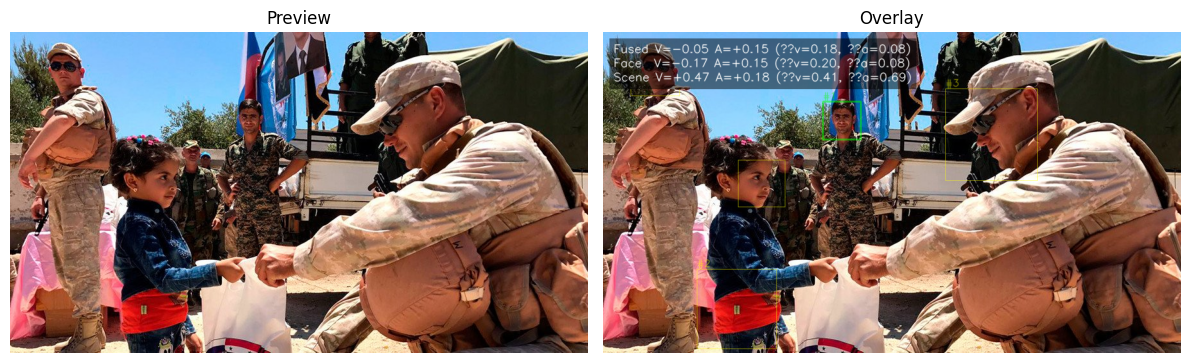

In [20]:
# Experiment:
# Choose a sample key or provide a custom path, then run this cell.

SAMPLE_KEY = "random"  # Options: with_face, no_face, with_face_far, random; set to None for custom path.
CUSTOM_IMG_PATH = (
    ""  # Fill with absolute or repo-relative path when SAMPLE_KEY is None.
)
RANDOM_SEED = 100  # Set to an int for reproducible random selection.

if SAMPLE_KEY is not None:
    key = SAMPLE_KEY.lower()
    valid = ", ".join(list(SAMPLE_IMAGES) + ["random"])
    if key not in SAMPLE_IMAGES and key != "random":
        raise SystemExit(f"Unknown SAMPLE_KEY {SAMPLE_KEY!r}. Valid options: {valid}")
    if key == "random":
        chosen = get_random_dataset_image(seed=RANDOM_SEED)
        IMG_PATH = str(chosen)
        if RANDOM_SEED is None:
            LABEL = f"PERCEIVE — random ({chosen.name})"
        else:
            LABEL = f"PERCEIVE — random ({chosen.name}, seed={RANDOM_SEED})"
    else:
        IMG_PATH = SAMPLE_IMAGES[key]
        LABEL = f"PERCEIVE — {key}"
else:
    if not CUSTOM_IMG_PATH:
        raise SystemExit("Set SAMPLE_KEY or CUSTOM_IMG_PATH before running.")
    IMG_PATH = CUSTOM_IMG_PATH
    LABEL = f"PERCEIVE — {IMG_PATH}"

run_experiment(IMG_PATH, label=LABEL)
